### Exploratory Data Analysis

In [1]:
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from IPython.display import display
from lifetimes import utils as lftutls

In [2]:
data_dict = {}
files = [file for file in listdir('.') if file.endswith('.csv')]

for file in files:
    temp_df = pd.read_csv(file, index_col=0)
    table_name = file.split('.csv')[0]
    data_dict[table_name] = temp_df
    print(table_name, end='\n\n')
    #display(temp_df.isnull().any(), )
    display(temp_df.info(), temp_df.nunique())
    print('*' * 100, end='\n\n')

customer_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_order_id   99441 non-null  object
 1   customer_unique_id  99441 non-null  object
 2   zipcode             99441 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.0+ MB


None

customer_order_id     99441
customer_unique_id    96096
zipcode               14994
dtype: int64

****************************************************************************************************

order_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   order_id           99441 non-null  object
 1   customer_order_id  99441 non-null  object
 2   order_status       99441 non-null  object
 3   purchased_at       99441 non-null  object
 4   approved_at        99281 non-null  object
 5   delivered_at       96476 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


None

order_id             99441
customer_order_id    99441
order_status             8
purchased_at         98875
approved_at          90733
delivered_at         95664
dtype: int64

****************************************************************************************************

order_product_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   order_id            112650 non-null  object 
 1   num_items_in_order  112650 non-null  int64  
 2   product_id          112650 non-null  object 
 3   price               112650 non-null  float64
 4   shipping            112650 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.2+ MB


None

order_id              98666
num_items_in_order       21
product_id            32951
price                  5968
shipping               6999
dtype: int64

****************************************************************************************************

product_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32328 entries, 0 to 32327
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_id        32328 non-null  object
 1   number_of_photos  32328 non-null  int64 
 2   category          32328 non-null  object
dtypes: int64(1), object(2)
memory usage: 1010.2+ KB


None

product_id          32328
number_of_photos       19
category               41
dtype: int64

****************************************************************************************************



Entity Relationship Summary:
- customer_data: unique order_id, non-unique cust_id
    - customers have multiple orders
- order_data: order_id, cust_order_id unique
    - missing data in processed and delivery date columns
- order_product_data: non-unique order_id & product_id
    -  **num_items_in_order is misleading, it indicates the position of item in order**
    -  **this would be a multiset table if not for num_items_in_order, redundant column**
- product_data: unique product_id

<AxesSubplot:>

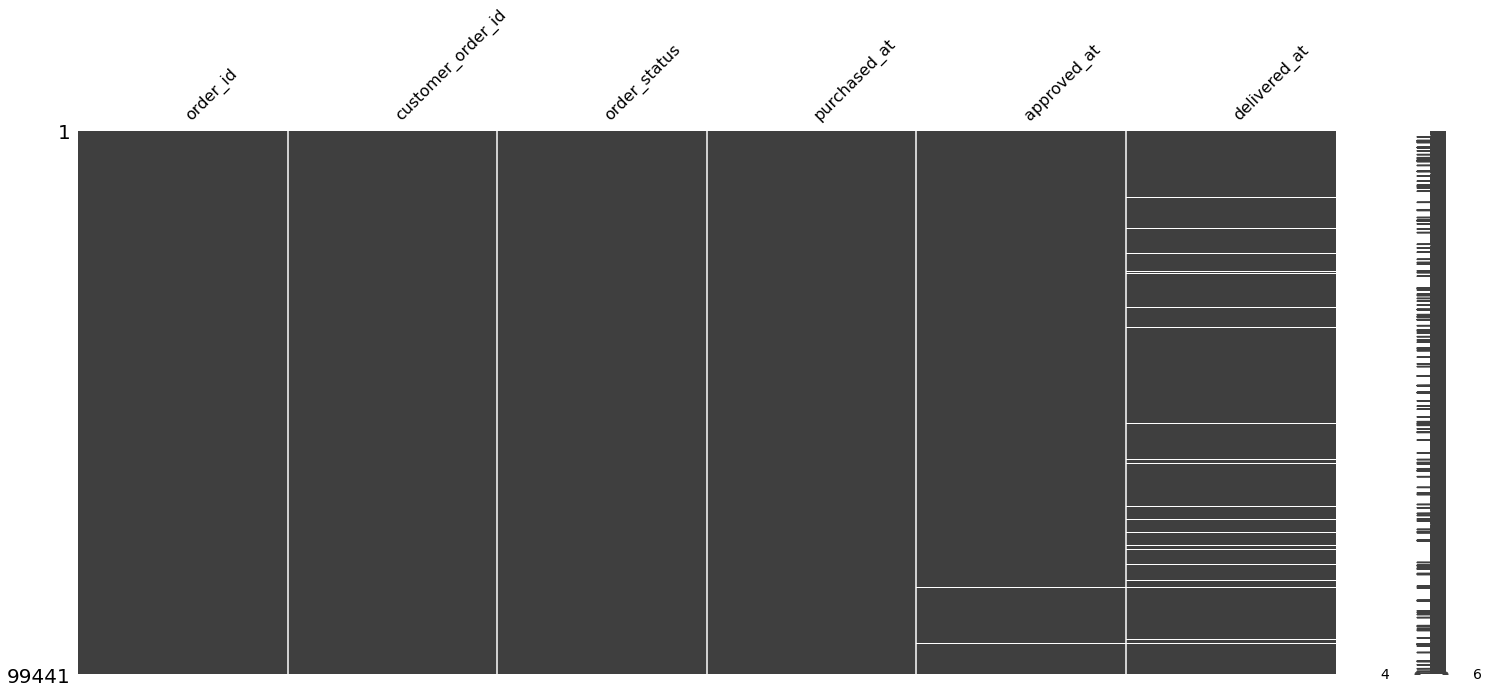

In [3]:
order_data = data_dict['order_data']
msno.matrix(order_data)

- Assume all orders are delivered (no refunds, no exchanges, no partial-orders)
    - Possible imputation using max delivery diff
    - correlated missing data for order approval and delivery (NMAR)

In [4]:
missing_dt = order_data.approved_at.isnull() & order_data.approved_at.isnull()

In [5]:
order_data[missing_dt].order_status.value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

### Join Order Customer Table

In [6]:
order_data['purchased_at'] = pd.to_datetime(order_data.purchased_at)
order_data['approved_at'] = pd.to_datetime(order_data.approved_at)
order_data['delivered_at'] = pd.to_datetime(order_data.delivered_at)

In [7]:
order_customer = order_data.merge(data_dict['customer_data'], on='customer_order_id')
order_customer.sample(3)

,order_id,customer_order_id,order_status,purchased_at,approved_at,delivered_at,customer_unique_id,zipcode
42539,345a398e91fef84fbffb9c07611c9959,7185fdbf483003e78b65e2571d89976f,processing,2017-05-07 22:55:53,2017-05-07 23:05:13,NaT,c012dc15bf0773671a901e6b6e032c95,56328
56255,1b639d1c43c530ad38bb59d4ea7f8d08,ce65d81faff1e65d08d331bfe6c0ad6e,delivered,2017-12-29 18:23:19,2017-12-30 14:27:40,2018-01-30 21:42:48,5ee8f21bffc44f0d99469baeb26d0dfc,76829
88602,0549a140f31f96d7cafd46b91d604c06,c798702c7aeaca1e47c10e45742b5c02,delivered,2018-05-06 21:44:22,2018-05-07 10:11:18,2018-05-14 17:12:01,6b4f9db3932e60d8255df92acff8edd7,3260


In [8]:
order_customer.info(), order_customer.nunique() # validate 99441 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            99441 non-null  object        
 1   customer_order_id   99441 non-null  object        
 2   order_status        99441 non-null  object        
 3   purchased_at        99441 non-null  datetime64[ns]
 4   approved_at         99281 non-null  datetime64[ns]
 5   delivered_at        96476 non-null  datetime64[ns]
 6   customer_unique_id  99441 non-null  object        
 7   zipcode             99441 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(4)
memory usage: 6.8+ MB


(None,
 order_id              99441
 customer_order_id     99441
 order_status              8
 purchased_at          98875
 approved_at           90733
 delivered_at          95664
 customer_unique_id    96096
 zipcode               14994
 dtype: int64)

### Join Order-Product Product Table

In [9]:
order_product_data = data_dict['order_product_data']
order_product_data.sample(2)

,order_id,num_items_in_order,product_id,price,shipping
10863,18bfcd3049f8effbdf7a7e9b11d07f38,1,85337022853da10b8f5fd7d1ef180421,39.9,34.15
101349,e5e40991ee40d56c69312d1736f84cdd,1,125efe6153a8b6ed25ed7cabdd43c1a6,13.5,15.11


In [10]:
# caution: num_items_in_order
order_product_agg = order_product_data.groupby(['order_id', 'product_id']).agg({'num_items_in_order' : 'count',
                                                                                'price' : 'sum',
                                                                                'shipping': 'sum'}).reset_index()

In [11]:
# validation
order_product_agg[order_product_agg.order_id.isin(['00143d0f86d6fbd9f9b38ab440ac16f5'])] # matches Readme

,order_id,product_id,num_items_in_order,price,shipping
31,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,3,63.99,45.3


In [12]:
#Left Join not all ord_ids will have valid categories
order_product_det = order_product_agg.merge(data_dict['product_data'], on='product_id', how='left')
order_product_det.sample(3)

,order_id,product_id,num_items_in_order,price,shipping,number_of_photos,category
61648,9b28ecb03bbb9a5081729d9f822f46a1,1a053f9619cbdb4a83c0f61a68d01211,1,20.99,15.25,2.0,sports
64179,a14990206b64de40d5aa9e4a235bcc64,ecaaaccb5eb3102553f001d62db6389e,1,288.92,16.77,2.0,computers_accessories
86873,d8d344285c3eb8fe24478102c93f6e94,d06d1c1f54c64e227690d22eb48855b2,1,43.20,14.10,3.0,sports


In [13]:
order_product_det['total'] = order_product_det.price + order_product_det.shipping

In [14]:
order_product_det.info(), order_product_det.nunique()  #validate order_id 98666

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102425 entries, 0 to 102424
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   order_id            102425 non-null  object 
 1   product_id          102425 non-null  object 
 2   num_items_in_order  102425 non-null  int64  
 3   price               102425 non-null  float64
 4   shipping            102425 non-null  float64
 5   number_of_photos    100943 non-null  float64
 6   category            100943 non-null  object 
 7   total               102425 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 7.0+ MB


(None,
 order_id              98666
 product_id            32951
 num_items_in_order       16
 price                  6981
 shipping               7969
 number_of_photos         19
 category                 41
 total                 31223
 dtype: int64)

In [15]:
order_product_det[order_product_det.order_id.isin(['00143d0f86d6fbd9f9b38ab440ac16f5'])]  #validate 63.99, 45.30

,order_id,product_id,num_items_in_order,price,shipping,number_of_photos,category,total
31,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,3,63.99,45.3,1.0,sports,109.29


In [16]:
# validation ordr id: nunique > 1 item |(given) count == 1
order_product_det[order_product_det.order_id.isin(['002f98c0f7efd42638ed6100ca699b42'])]

,order_id,product_id,num_items_in_order,price,shipping,number_of_photos,category,total
73,002f98c0f7efd42638ed6100ca699b42,880be32f4db1d9f6e2bec38fb6ac23ab,1,44.90,7.16,4.0,toys,52.06
74,002f98c0f7efd42638ed6100ca699b42,d41dc2f2979f52d75d78714b378d4068,1,8.99,32.57,1.0,games,41.56


### Create Master Table

In [17]:
ord_cus_prod = order_customer.merge(order_product_det, how='outer')  #not all ord_id have valid categories and products

In [18]:
ord_cus_prod.info(), ord_cus_prod.nunique()  # validate order_id 99441

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103200 entries, 0 to 103199
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            103200 non-null  object        
 1   customer_order_id   103200 non-null  object        
 2   order_status        103200 non-null  object        
 3   purchased_at        103200 non-null  datetime64[ns]
 4   approved_at         103040 non-null  datetime64[ns]
 5   delivered_at        100195 non-null  datetime64[ns]
 6   customer_unique_id  103200 non-null  object        
 7   zipcode             103200 non-null  int64         
 8   product_id          102425 non-null  object        
 9   num_items_in_order  102425 non-null  float64       
 10  price               102425 non-null  float64       
 11  shipping            102425 non-null  float64       
 12  number_of_photos    100943 non-null  float64       
 13  category            100943 no

(None,
 order_id              99441
 customer_order_id     99441
 order_status              8
 purchased_at          98875
 approved_at           90733
 delivered_at          95664
 customer_unique_id    96096
 zipcode               14994
 product_id            32951
 num_items_in_order       16
 price                  6981
 shipping               7969
 number_of_photos         19
 category                 41
 total                 31223
 dtype: int64)

### Summary

##### Examining the Purchase activity in our dataset, we can see the first transaction occurs September 4, 2016 and the last activity is on October 17, 2018 making the dataset a little more than 2 years in duration.

In [19]:
order_customer.purchased_at.describe(datetime_is_numeric=True)

count                            99441
mean     2017-12-31 08:43:12.776581120
min                2016-09-04 21:15:19
25%                2017-09-12 14:46:19
50%                2018-01-18 23:04:36
75%                2018-05-04 15:42:16
max                2018-10-17 17:30:18
Name: purchased_at, dtype: object

##### In this roughly 2-year period, we see over 96K unique customers, generating just over 99K thousand unique transactions and revenue of about $15.8 Million[<sup>1</sup>](#fn1)


The lowest and highest transaction amounts are <b>\\$9.59</b> and <b>\\$13,644</b> respectively. The mean amount is <b>\\$160.58</b>

<span id="fn1">1.</span> Excluding revenue from missing pricing and shipping costs (due to missing items in the product catalog)

In [20]:
order_customer.order_id.count(), order_customer.customer_unique_id.nunique()

(99441, 96096)

In [21]:
total_by_ordr = order_product_det.groupby('order_id').total.sum()

sum(order_product_det.total), total_by_ordr.describe()

(15843553.239998933,
 count    98666.000000
 mean       160.577638
 std        220.466087
 min          9.590000
 25%         61.980000
 50%        105.290000
 75%        176.870000
 max      13664.080000
 Name: total, dtype: float64)

##### The transaction frequency (histogram) shows that the retailer is on the downturn in customer activity, and there does not seem to be an obvious volatility nor a seasonal impact

Text(0.5, 1.0, 'Transaction Frequency')

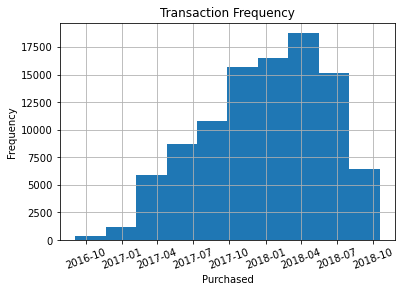

In [22]:
order_customer.purchased_at.hist(xrot='20')

plt.xlabel('Purchased')
plt.ylabel('Frequency')
plt.title('Transaction Frequency')

##### Avg. Unique Orders/Customer

In [23]:
ordrs_by_cust = order_customer.groupby("customer_unique_id").order_id.count()
print(f'The Avg Unique TXNs per customer is %.2f' % ordrs_by_cust.mean())

The Avg Unique TXNs per customer is 1.03


##### Avg. Unique Products/Customer

In [24]:
# Missing Product IDs (First Impute NaNs)
na_prods_by_cust = ord_cus_prod.reset_index()[ord_cus_prod.product_id.isnull()].groupby(
    'customer_unique_id').agg({'product_id': 'size', 'index': 'max'})
na_prods_by_cust.product_id.value_counts()

1    748
2     12
3      1
Name: product_id, dtype: int64

In [25]:
impute_prod_idx = na_prods_by_cust.loc[na_prods_by_cust.product_id == 1, 'index'].values

In [26]:
# impute single product N/As treating them as arbitrary product id
ord_cus_prod.loc[impute_prod_idx, 'product_id'] = 'Missing'

In [27]:
# Avg. Unique Prod/Cust
prods_per_cust = ord_cus_prod.dropna(subset=['product_id']).groupby("customer_unique_id").product_id.nunique()
print(f'Avg Unique Product(s) Purchases per customer is %.2f' % prods_per_cust.mean())

Avg Unique Product(s) Purchases per customer is 1.07


##### Bins: Unique TXNs/Cust, Unique Prods/Cust & Unique Revenue/Category

##### The next couple of graphs show that our sales follow the Pareto Principle; Majority of customers are making a one-time purchase of a single item. Following the 80/20 principal we can determine that important/trending product categories that represent majority of the revenue (see Top Categories chart below).

In [28]:
txns_per_cust_bins = ordrs_by_cust.value_counts().sort_index()
prods_per_cust_bins = prods_per_cust.value_counts().sort_index()

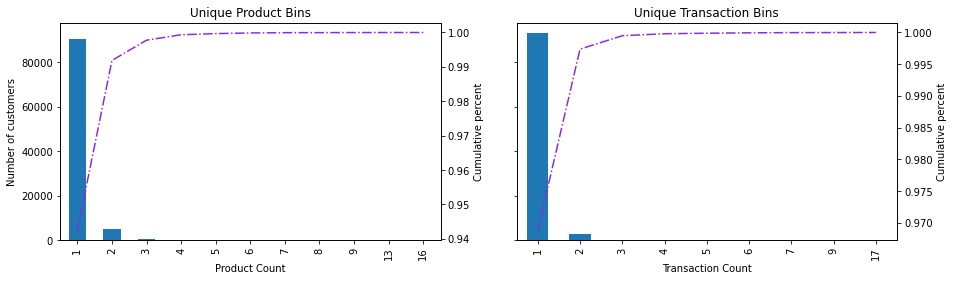

In [55]:
# plot of number of orders per customer
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharey=True)
axesA, axesB = axes
axesA.set_title('Unique Product Bins')
axesB.set_title('Unique Transaction Bins')

prods_per_cust_bins.plot.bar(ax=axesA)

pct_cumsum_prods = (prods_per_cust_bins.cumsum() / prods_per_cust_bins.sum()) * 100

ax2=axesA.twinx()
axesA.set_ylabel("Number of customers")
axesA.set_xlabel("Product Count")
ax2.set_ylabel("Cumulative percent")
ax2.plot(range(len(prods_per_cust_bins)), pct_cumsum_prods, linestyle='dashdot', color='blueviolet')

# plot of number of items bought per customer
txns_per_cust_bins.plot.bar(ax=axesB)

pct_cumsum_txns = (txns_per_cust_bins.cumsum() / txns_per_cust_bins.sum()) * 100

ax3=axesB.twinx()
axesB.set_ylabel("Number of customers")
axesB.set_xlabel("Transaction Count")
ax3.set_ylabel("Cumulative percent")
ax3.plot(range(len(txns_per_cust_bins)), pct_cumsum_txns, linestyle='dashdot', color='blueviolet')

In [61]:
cat_total = order_product_det.groupby('category').total.sum().sort_values(ascending=False)

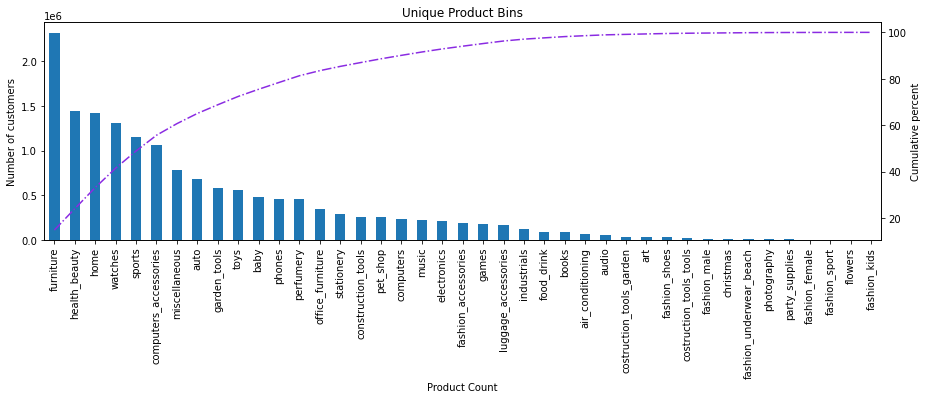

In [62]:
# plot of number of orders per customer
fig, axes = plt.subplots(figsize=(15, 4))
axes.set_title('Top Categories')

cat_total.plot.bar(ax=axes)

pct_cumsum_cat = (cat_total.cumsum() / cat_total.sum()) * 100

ax2=axes.twinx()
axes.set_ylabel("Number of customers")
axes.set_xlabel("Product Count")
ax2.set_ylabel("Cumulative percent")
ax2.plot(range(len(cat_total)), pct_cumsum_cat, linestyle='dashdot', color='blueviolet')

##### By defining individual transactions as unique days in which one or more purchases are made, we can examine the distribution of the days between purchase events. In this way, the more active the customer, the smaller the difference of days between purchases. The time since we last saw a customer is a critical factor to determining whether they will ever come back with the probability of return dropping as more and more time passes since a customer's last purchase event.

##### The descriptive statistics show that most customers return to the site within 2 to 3 months after their previous purchase. Longer gaps like 6 months do occur but significantly fewer customers have longer gaps between returns. 

In [32]:
cust_purdt = order_customer.groupby(['customer_unique_id',
                                     pd.to_datetime(order_customer.purchased_at.dt.date)]).size()

In [33]:
cust_purdt = cust_purdt.sort_index().reset_index()

In [34]:
cust_purdt['prev_pur_dt'] = cust_purdt.groupby(['customer_unique_id']).purchased_at.shift()

In [35]:
cust_purdt['diff_days'] = (cust_purdt.purchased_at - cust_purdt.prev_pur_dt).apply(lambda x: x.days)

In [36]:
cust_purdt_diffs = cust_purdt.dropna().groupby('customer_unique_id').diff_days.mean()  # Multiple Transactions only

In [37]:
cust_purdt.diff_days.describe()

count    2384.000000
mean      109.758809
std       112.944779
min         1.000000
25%        22.000000
50%        67.000000
75%       168.000000
max       609.000000
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Probability Density of Avg. days between purchases')

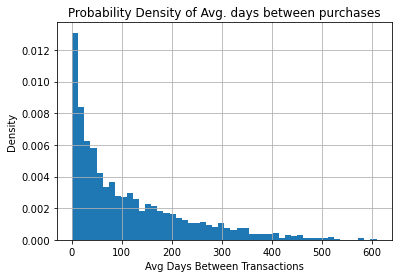

In [38]:
cust_purdt_diffs.hist(density=True, bins=50)
plt.xlabel('Avg Days Between Transactions')
plt.ylabel('Density')
plt.title('Probability Density of Avg. days between purchases')

### RFM Dataset/Per-Customer Metrics

- Recency: Last purchase date - inital purchase date (same as avg. days between transactions from prev. step)
- Frequency: Number of repeat purchases
- T: time delta between max date and last purchase date

In [39]:
rfm_df = (
  lftutls.summary_data_from_transaction_data(
    order_customer,
    customer_id_col='customer_unique_id',
    datetime_col='purchased_at',
    observation_period_end = order_customer.purchased_at.dt.date.max(),
    freq='D'
    )
  )

In [40]:
freq_recency = rfm_df.groupby('frequency').agg({'recency' : ['count', 'mean']}).reset_index()
freq_recency

frequency recency            
              count        mean
0       0.0   93947    0.000000
1       1.0    1983  114.877963
2       2.0     133  188.849624
3       3.0      19  264.526316
4       4.0       5  258.000000
5       5.0       6  273.166667
6       6.0       2  164.000000
7      16.0       1  462.000000

### Output files for dashboard

In [41]:
ord_cus_prod.to_csv('master.csv', index=False)
freq_recency.to_csv('freq_recency.csv', index=False)